1) Data is tif files stored in directory src/data/originals
2) Maps corresponding to the same region are stored in the same folder
3) Convert each of the maps to patches
4) Apply the alignment (use the oldest map as the reference map - the one with the smalles)
5) Format to feed to network (?)

In [1]:
import PIL
import os
import logging
import pickle as pk
from copy import deepcopy

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify,unpatchify
import cv2 as cv

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

logging.basicConfig(format='%(asctime)s %(levelname)-4s %(message)s',
                    level=logging.INFO,
                    datefmt='%d-%m-%Y %H:%M:%S')

logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

PIL.Image.MAX_IMAGE_PIXELS = 933120000

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode
from skimage.measure import block_reduce
from torch.utils.data import Dataset,DataLoader

from torchvision.models.resnet import resnet50, ResNet50_Weights

In [4]:
class MapPatch():
    def __init__(self, patch, patch_index, origin_map):
        self.patch = patch
        self.patch_index = patch_index
        self.origin_map = origin_map
        self.patch_shift = None
        
    @staticmethod
    def get_map_patches(file_name, patch_width, verbose = True):
        tif_map = PIL.Image.open(file_name)
        tif_map_np = np.array(tif_map)
        
        tif_map_patches = patchify(image = tif_map_np, 
                                   patch_size = (patch_width, patch_width, 3),
                                   step = patch_width)

        if verbose:
            logging.info(f"{np.prod(tif_map_patches.shape[:2]):,} patches from {file_name} generated with shape {tif_map_patches.shape}")

        return tif_map_np, tif_map_patches
    
    @staticmethod
    def get_map_patch_list(file_name, patch_width, verbose = True):
        _, tif_map_patches = MapPatch.get_map_patches(file_name, 
                                                      patch_width, 
                                                      verbose = verbose)
        
        patches = [MapPatch(tif_map_patches[i,j,0], patch_index = (i,j), origin_map = file_name)
                  for i in range(tif_map_patches.shape[0])
                  for j in range(tif_map_patches.shape[1])]
                
        return patches
    
    def get_map_px(self):
        """
        Gets location of the top left pixel of the patch in the original image.
        """
        patch_size = self.patch.shape[0]
        row = self.patch_index[0]
        col = self.patch_index[1]
        
        return (row * patch_size, col * patch_size)
    
    def show(self, verbose = True):
        """
        Shows the patch.
        """
        fig, ax = plt.subplots()
        ax.imshow(self.patch)
        
        if verbose:
            ax.set_title(f"Patch at {self.patch_index} from {self.origin_map}.")
            
        plt.show()

In [111]:
class CLPatchDataset(Dataset):
    def __init__(self, X_1, X_2):
        self.X_1 = X_1
        self.X_2 = X_2
    
    def __len__(self):
        return len(self.X_1)
    
    def __getitem__(self, i):
        
        if isinstance(i, slice):
            start = i.start if i.start else 0
            stop = i.stop if i.stop else len(self.patches)
            step = i.step if i.step else 1
            
            return [(self.X_1[j], self.X_2[j]) for j in range(start, stop, step)]
        
        return (self.X_1[i].patch, self.X_2[i].patch)
    
    @classmethod
    def from_dir(cls, map_directory, patch_width, verbose = False):
        X_1 = []
        X_2 = []

        for folder in os.listdir(map_directory):
            if folder.isdigit():
                if verbose:
                    logging.info(f"Fetching patches from folder: {folder}")
                    
                directory = os.path.join(map_directory, folder)
                patch_list = CLPatchDataset.get_patch_list_from_dir(directory, patch_width = patch_width, verbose = False)
                x_1, x_2 = CLPatchDataset.get_matching_patch_list(patch_list)
                X_1.extend(x_1)
                X_2.extend(x_2)
            
        return cls(X_1, X_2)
    
    @staticmethod
    def index_sampler(indices, n_samples = 4):
        return [indices[i] for i in np.random.choice(len(indices), n_samples, replace=False)]

    @staticmethod
    def get_patch_list_from_dir(directory, patch_width, verbose = False):
        patches = []

        for file in os.listdir(directory):
            if file.endswith("tif"):
                file_name = f"{directory}/{file}"
                patches.append(MapPatch.get_map_patch_list(file_name = file_name, 
                                                           patch_width = patch_width, 
                                                           verbose = verbose))

        return patches
    
    @staticmethod
    def is_empty_patch(patch):
        gray = cv.cvtColor(np.array(patch), cv.COLOR_RGB2GRAY)
        gray = cv.GaussianBlur(gray, (3,3), 0)
        edges = cv.Canny(gray, 50, 150)
        black_pixels = np.where(edges == 255)

        return len(black_pixels[0]) <= 20
    
    @staticmethod
    def get_matching_patch_list(patch_list):
        n_samples = len(patch_list)
        indices = [(i,j) for i in range(n_samples) for j in range(i) if i != j]

        x_1 = []
        x_2 = []

        for i in range(len(patch_list[0])):
            #sample_indices = CLPatchDataset.index_sampler(indices, n_samples)
            sample_indices = [(i,i+1) for i in range(n_samples-1)]
            for index in sample_indices:
                try:
                    patch_1 = patch_list[index[0]][i]
                    patch_2 = patch_list[index[1]][i]
                    if not CLPatchDataset.is_empty_patch(patch_1.patch) and not CLPatchDataset.is_empty_patch(patch_2.patch):
                        x_1.append(patch_1)
                        x_2.append(patch_2)
                except IndexError:
                    print(f"Faulty generated index: {index}")
                    print(f"Index i: {i}")
                    print(f"len(patch_list): {len(patch_list)}")
                    print(f"len(patch_list[index[0]]): {len(patch_list[index[0]])}")
                    print(f"len(patch_list[index[1]]): {len(patch_list[index[1]])}")
                    raise ValueError()

        return x_1, x_2
    
    def to_pickle(self, file_name = None):
        with open(f"{file_name}.pk", "wb") as f:
            pk.dump(self.patches, f)

In [4]:
class MapSIMCLR(nn.Module):
    def __init__(self):
        super(MapSIMCLR, self).__init__()
        
        # model hyperparameters
        self.MAX_PIXEL_VALUE = 255
        self.RESNET_DIM = 224
        self.RESNET_OUTPUT_DIM = 1000
        self.HIDDEN_DIM = 1500
        self.OUTPUT_DIM = 100
        
        # resnet for encoding input images
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # network layers for the projection head
        self.lin_hidden = nn.Linear(in_features=self.RESNET_OUTPUT_DIM, out_features=self.HIDDEN_DIM, bias = False)
        self.batch_norm = nn.BatchNorm1d(num_features = self.HIDDEN_DIM)
        self.relu = nn.ReLU()
        self.lin_output = nn.Linear(in_features = self.HIDDEN_DIM, out_features = self.OUTPUT_DIM, bias = False)
        
        # define the model
        self.model = nn.Sequential(
                self.resnet,
                self.lin_hidden,
                self.batch_norm,
                self.relu,
                self.lin_output
                )
        
        # define optimiser
        self.optimiser = None

        # get the device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def img_to_resnet(self, img, dim = None):
        """
        Convert image into the desired format for ResNet.
        The image must have width and height of at least self.RESNET_DIM, with RGB values between 0 and 1.
        Moreover, it must be normalised, by using a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
        --------------------------------------------------------------------------------------------------------------------------------
        :param img: a numpy nd.array, with 3 colour channels (this must be stored in the last dimensions), which has to be fed to ResNet
        :param dim: the desired dimension of the image (if we want to resize img before feeding it to ResNet).
                    This should be at least self.RESTNET_DIM.
        --------------------------------------------------------------------------------------------------------------------------------
        :return a Tensor, with the first dimension corresponding to the RGB channels, and normalised to be used by ResNet.
        """
        
        # put the colour channel in front and normalise into range [0,1]
        if len(img.shape) == 3:
            norm_img = torch.moveaxis(img, -1, 0)/self.MAX_PIXEL_VALUE
        else:
            norm_img = torch.moveaxis(img, -1, 1)/self.MAX_PIXEL_VALUE
        
        # resize
        if dim is not None:
            assert dim >= self.RESNET_DIM, f"Provided dimension {dim} is less than the required for RESNET ({self.RESNET_DIM})"
            norm_img = T.Resize(dim)(norm_img)  
        else:
            norm_img = T.Resize(self.RESNET_DIM)(norm_img)
        
        # normalise mean and variance
        mean = torch.Tensor([0.485, 0.456, 0.406])
        std = torch.Tensor([0.229, 0.224, 0.225])
        
        return T.Normalize(mean = mean, std = std)(norm_img)
    
    def contrastive_loss(self, z_batch, tau):
        """
        Computes the contrastive loss (NT-XENT) for a mini-batch of augmented samples.
        --------------------------------------------------------------------------------------------------------
        z_batch: a (N,K) Tensor, with rows as embedding vectors. 
                 We expect that z_batch[2k] and z_batch[2k+1], 0 <= k < N, correspond to a positive sample pair
        tau: temperature parameter for NT-XENT loss
        --------------------------------------------------------------------------------------------------------
        return: a float, corresponding to the total loss for the mini-batch z_batch
        """
        N = len(z_batch)

        # normalise to have unit length rows
        norm_z_batch = F.normalize(z_batch)

        # compute similarity & apply factor of tau
        sim_batch = (norm_z_batch @ norm_z_batch.T)/tau

        # fill the diagonal with -1000, to make sure it is never considered in the cross entropy computations
        sim_batch.fill_diagonal_(-1000)

        # generate labels
        # z_batch[2k] should be similar to z_batch[2k+1] (since these will be the positive pair)
        # hence, labels should have the form [1,0,3,2,...,N,N-1]
        labels = torch.Tensor([k+1 if k%2 == 0 else k-1 for k in range(0,N)]).long().to(self.device)

        # return the NT-XENT loss
        return 1/N * F.cross_entropy(sim_batch, labels, reduction = "sum")
    
    def forward(self, x):
        """
        A forward pass through the network
        """
        res_x = self.img_to_resnet(x)
        
        return self.model(res_x)
        
    
    def compile_optimiser(self, **kwargs):
        """
        Sets the optimiser parameters.
        """
        self.optimiser = optim.Adam(self.parameters(), **kwargs)
    
    def train(self, dataloader, tau, epochs):
        """
        Trains the network.
        """

        self.to(self.device)

        for epoch in range(epochs):
            batch_losses = []
            for batch, (x_1,x_2) in enumerate(dataloader):
                # x_1 and x_2 are tensors containing patches, 
                # such that x_1[i] and x_2[i] are patches for the same area
                
                self.optimiser.zero_grad()

                x_1, x_2 = x_1.to(self.device), x_2.to(self.device)
                
                z_1 = self(x_1)
                z_2 = self(x_2)
                
                z_batch = torch.stack((z_1,z_2), dim = 1).view(-1, self.OUTPUT_DIM)
                loss = self.contrastive_loss(z_batch, tau = tau)

                batch_losses.append(loss.cpu())
                
                loss.backward()
                self.optimiser.step()

                if batch % (len(dataloader) // 100 + 1) == 0:
                    with torch.no_grad():
                        avg_loss = np.mean(batch_losses[-20:])
                        print(f"Epoch {epoch + 1}: [{batch + 1}/{len(dataloader)}] ---- NT-XENT = {avg_loss}")

In [75]:
class MLP(nn.Module):
    """
    Class encoding a simple multi-layer perceptron, used for encoding and prediction.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, activation = nn.ReLU(), use_bias = True, use_batch_norm = True):
        super(MLP, self).__init__()
        
        # network layers for the projection head
        self.lin_hidden = nn.Linear(in_features = input_dim, 
                                    out_features = hidden_dim, 
                                    bias = use_bias)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_dim) if use_batch_norm else nn.Identity()
        self.activation = activation
        self.lin_output = nn.Linear(in_features = hidden_dim, 
                                    out_features = output_dim, 
                                    bias = use_bias)
        
        # define the model
        self.mlp = nn.Sequential(
                self.lin_hidden,
                self.batch_norm,
                self.activation,
                self.lin_output
                )
        
    def forward(self, x):
        return self.mlp(x)
    
def img_to_resnet(img, dim = None):
        """
        Convert image into the desired format for ResNet.
        The image must have width and height of at least self.RESNET_DIM, with RGB values between 0 and 1.
        Moreover, it must be normalised, by using a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
        --------------------------------------------------------------------------------------------------------------------------------
        :param img: a tensor, with 3 colour channels (this must be stored in the last dimensions), 
                    which has to be fed to ResNet
        :param dim: the desired dimension of the image (if we want to resize img before feeding it to ResNet).
                    This should be at least self.RESNET_DIM.
        --------------------------------------------------------------------------------------------------------------------------------
        :return a Tensor, with the first dimension corresponding to the RGB channels, and normalised to be used by ResNet.
        """

        MAX_PIXEL_VALUE = 255
        RESNET_DIM = 224
        
        # put the colour channel in front and normalise into range [0,1]
        if len(img.shape) == 3:
            norm_img = torch.moveaxis(img, -1, 0)/MAX_PIXEL_VALUE
        else:
            norm_img = torch.moveaxis(img, -1, 1)/MAX_PIXEL_VALUE

        # resize
        if dim is not None:
            assert dim >= RESNET_DIM, f"Provided dimension {dim} is less than the required for RESNET ({RESNET_DIM})"
            norm_img = T.Resize(dim)(norm_img)  
        else:
            norm_img = T.Resize(RESNET_DIM)(norm_img)

        # normalise mean and variance
        mean = torch.Tensor([0.485, 0.456, 0.406])
        std = torch.Tensor([0.229, 0.224, 0.225])

        return T.Normalize(mean = mean, std = std)(norm_img)
    
# based on the Hook class by Kennethborup:
# https://github.com/Kennethborup/BYOL
class Hook():
    """
    A simple hook class that returns the output of a layer of a model during forward pass.
    """
    def __init__(self):
        self.output = None
        
    def set_hook(self, module):
        """
        Attaches hook to model.
        """
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, _, output):
        """
        Saves the wanted information.
        """
        self.output = output
        
        
class EncoderProjectorNN(nn.Module):
    """
    Class for a network which encodes an input and projects it into a latent space.
    """
    def __init__(self, encoder, projector, encoder_layer_idx = -1):
        super(EncoderProjectorNN, self).__init__()
        
        self.encoder = encoder
        self.projector = projector
        self.encoder_layer_idx = encoder_layer_idx
        
        if self.encoder_layer_idx != -1:
            self.hook = Hook()
            layers = [*self.encoder.children()]
            encoder_layer = layers[self.encoder_layer_idx]
            self.hook.set_hook(encoder_layer)
            
    def encode(self, x):
        
        encoded = self.encoder(x)
        
        if self.encoder_layer_idx != -1:
            # need to fix the output to remove the additional dimensions
            encoded = self.hook.output.reshape(encoded.shape[0],-1)
            
        return encoded
    
    def project(self, x):
        return self.projector(x)
    
    def forward(self, x):
        encode_x = self.encode(x)
        return self.project(encode_x)

class MapBYOL(nn.Module):
    """
    The BYOL model consists on 2 networks: an online and a target network.
    Traditionally, we have an input image x, which is then transformed into positive pairs v and v'.
    We train the online network, which consists of:
        - an encoder (which converts v to a vector representation y = f(v))
        - a projector (which projects y into latent space representation z = g(y))
        - a predictor (which predicts the latent representation for v' from v_sim = q(z))
    The latent representation for v' is obtained by applying the target network to v'.
    However, we don't directly train this target network; 
    instead, we use an EXPONENTIAL MOVING AVERAGE of the weights for the online network.
    The loss for this involves applying a cosine similarity (which is L2 normalised) between 
    v_sim and the latent representation for v'. Since the model isn't symmetric, 
    we compute the same loss, but this time passing v' through the online network, 
    and v through the target network. We then add these 2 losses to obtain the BYOL loss.
    Critically, we only compute gradients with respect to the parameters of the online network
    """
    def __init__(self, image_dim, encoder, encoder_layer_idx, projector_parameters, predictor_parameters, ema_tau):
        super(MapBYOL, self).__init__()
        
        self.ema_tau = ema_tau
        
        self.online_network = EncoderProjectorNN(encoder = encoder,
                                                 projector = MLP(**projector_parameters),
                                                 encoder_layer_idx = encoder_layer_idx)
        
        self.target_network = deepcopy(self.online_network)
        
        self.online_predictor = MLP(**predictor_parameters)

        self.optimiser = None

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @torch.no_grad()
    def update_target_network(self):
        for online_params, target_params in zip(self.online_network.parameters(), self.target_network.parameters()):
            target_params.data = self.ema_tau * target_params.data + (1 - self.ema_tau) * online_params.data
    
    @staticmethod
    def img_to_resnet(img, dim = None):
        """
        Convert image into the desired format for ResNet.
        The image must have width and height of at least self.RESNET_DIM, with RGB values between 0 and 1.
        Moreover, it must be normalised, by using a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
        --------------------------------------------------------------------------------------------------------------------------------
        :param img: a tensor, with 3 colour channels (this must be stored in the last dimensions), 
                    which has to be fed to ResNet
        :param dim: the desired dimension of the image (if we want to resize img before feeding it to ResNet).
                    This should be at least self.RESNET_DIM.
        --------------------------------------------------------------------------------------------------------------------------------
        :return a Tensor, with the first dimension corresponding to the RGB channels, and normalised to be used by ResNet.
        """

        MAX_PIXEL_VALUE = 255
        RESNET_DIM = 224
        
        # put the colour channel in front and normalise into range [0,1]
        if len(img.shape) == 3:
            norm_img = torch.moveaxis(img, -1, 0)/MAX_PIXEL_VALUE
        else:
            norm_img = torch.moveaxis(img, -1, 1)/MAX_PIXEL_VALUE

        # resize
        if dim is not None:
            assert dim >= RESNET_DIM, f"Provided dimension {dim} is less than the required for RESNET ({RESNET_DIM})"
            norm_img = T.Resize(dim)(norm_img)  
        else:
            norm_img = T.Resize(RESNET_DIM)(norm_img)

        # normalise mean and variance
        mean = torch.Tensor([0.485, 0.456, 0.406])
        std = torch.Tensor([0.229, 0.224, 0.225])

        return T.Normalize(mean = mean, std = std)(norm_img)
    
    def byol_loss(self, x_1, x_2):
        norm_x_1 = F.normalize(x_1, dim = -1, p = 2)
        norm_x_2 = F.normalize(x_2, dim = -1, p = 2)
        
        return 2 - 2 * (norm_x_1 * norm_x_2).sum(dim = -1)
    
    def forward(self, x):
        """
        Returns the encoding (without projection) of the input, corresponding to the online network.
        """
        return self.online_network.encode(x)

    def compile_optimiser(self, **kwargs):
        """
        Sets the optimiser parameters.
        """
        self.optimiser = optim.Adam(self.parameters(), **kwargs)
    
    def get_loss(self, x_1, x_2):
        online_projection_1 = self.online_network(x_1)
        online_projection_2 = self.online_network(x_2)

        with torch.no_grad():
            target_projection_1 = self.target_network(x_1)
            target_projection_2 = self.target_network(x_2)

        online_prediction_1 = self.online_predictor(online_projection_1)
        online_prediction_2 = self.online_predictor(online_projection_2)

        loss_1 = self.byol_loss(online_prediction_1, target_projection_2.detach())
        loss_2 = self.byol_loss(online_prediction_2, target_projection_1.detach())

        return (loss_1 + loss_2).mean()
                                                                            
    
    def train(self, dataloader, epochs, transform = None):
        """
        Trains the network.
        """

        self.to(self.device)

        for epoch in range(epochs):
            batch_losses = []
            for batch, (x_1,x_2) in enumerate(dataloader):
                # x_1 and x_2 are tensors containing patches, 
                # such that x_1[i] and x_2[i] are patches for the same area
                
                self.optimiser.zero_grad()

                x_1, x_2 = transform(x_1.to(self.device)), transform(x_2.to(self.device))
                
                loss = self.get_loss(x_1, x_2)

                batch_losses.append(loss.cpu())
                
                loss.backward()
                self.optimiser.step()
                self.update_target_network()

                if batch % (len(dataloader) // 100 + 1) == 0:
                    with torch.no_grad():
                        avg_loss = np.mean(batch_losses[-20:])
                        print(f"Epoch {epoch + 1}: [{batch + 1}/{len(dataloader)}] ---- BYOL-Loss = {avg_loss}")

In [69]:
projector_params = {"input_dim" : 2048, 
                    "hidden_dim" : 4096, 
                    "output_dim" : 256, 
                    "activation" : nn.ReLU(), 
                    "use_bias" : True,
                    "use_batch_norm" : True}

encoder = resnet50(weights=ResNet50_Weights.DEFAULT)
projector = MLP(**projector_params)
enproj = EncoderProjectorNN(encoder = encoder, projector = projector, encoder_layer_idx = -2)

----------

In [113]:
def show_patch_pairs(patches):
    for patch_1, patch_2 in patches:
        fig, ax = plt.subplots(1,2,figsize = (10,5))
        ax[0].imshow(patch_1)
        ax[1].imshow(patch_2)
        plt.show()

In [114]:
cl_patch_dataset = CLPatchDataset.from_dir("../src/data/originals", 64, verbose = True)

14-01-2023 11:22:21 INFO Fetching patches from folder: 50
14-01-2023 11:22:23 INFO Fetching patches from folder: 57
14-01-2023 11:22:25 INFO Fetching patches from folder: 32
14-01-2023 11:22:28 INFO Fetching patches from folder: 35
14-01-2023 11:22:32 INFO Fetching patches from folder: 56
14-01-2023 11:22:36 INFO Fetching patches from folder: 51
14-01-2023 11:22:38 INFO Fetching patches from folder: 34
14-01-2023 11:22:41 INFO Fetching patches from folder: 33
14-01-2023 11:22:45 INFO Fetching patches from folder: 20
14-01-2023 11:22:47 INFO Fetching patches from folder: 18
14-01-2023 11:22:52 INFO Fetching patches from folder: 9
14-01-2023 11:22:56 INFO Fetching patches from folder: 7
14-01-2023 11:23:00 INFO Fetching patches from folder: 29
14-01-2023 11:23:04 INFO Fetching patches from folder: 16
14-01-2023 11:23:09 INFO Fetching patches from folder: 42
14-01-2023 11:23:12 INFO Fetching patches from folder: 45
14-01-2023 11:23:14 INFO Fetching patches from folder: 6
14-01-2023 11:23:

In [115]:
len(cl_patch_dataset)

193133

In [119]:
cl_patch_loader = DataLoader(cl_patch_dataset, batch_size = 50, shuffle = True)

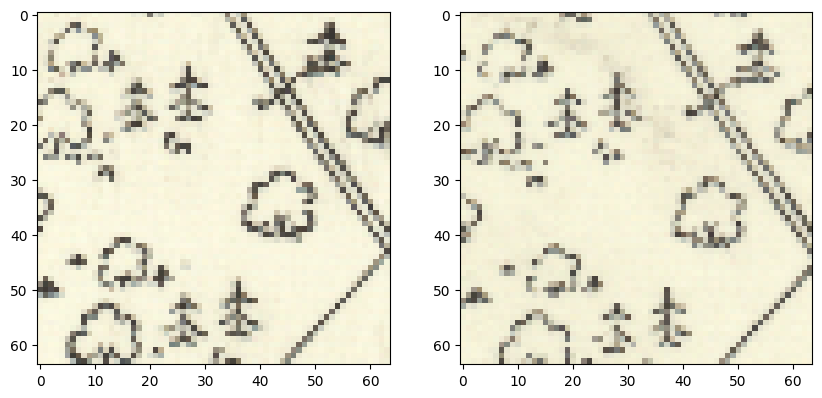

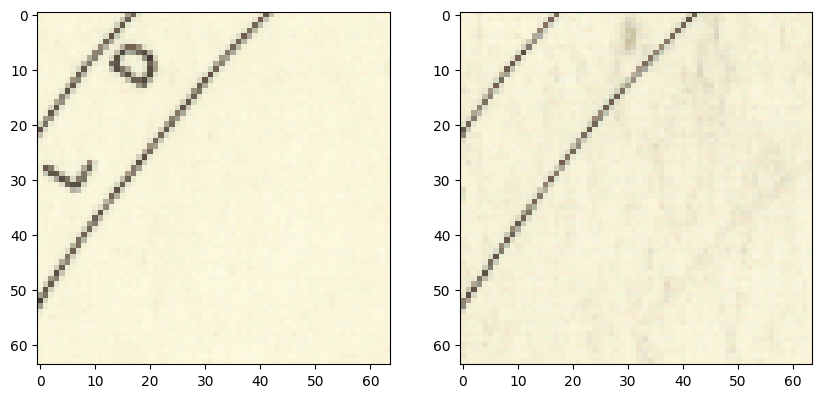

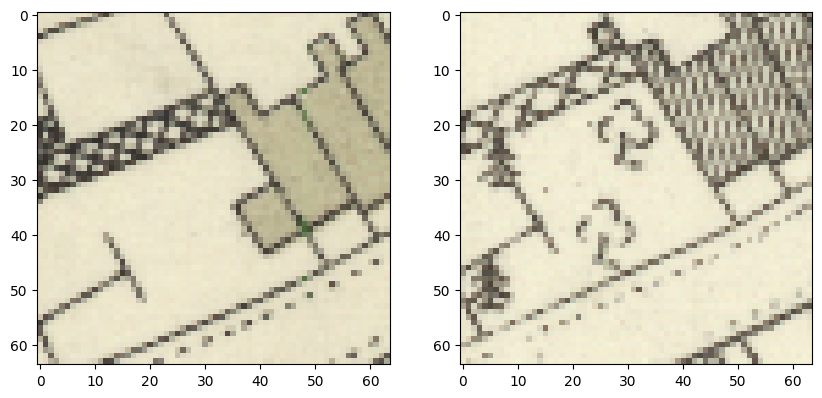

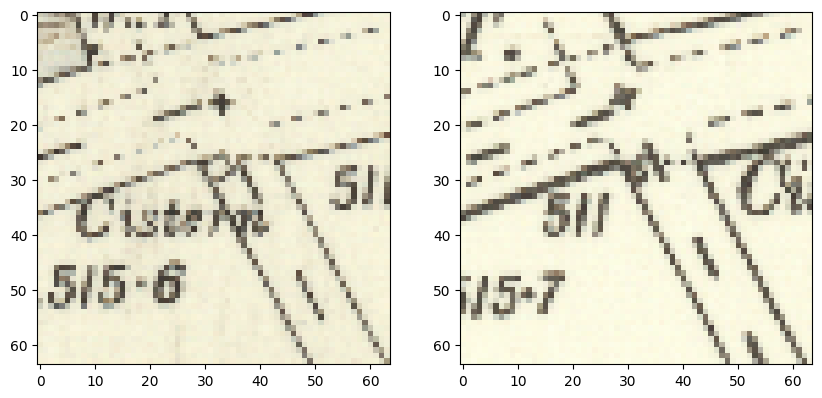

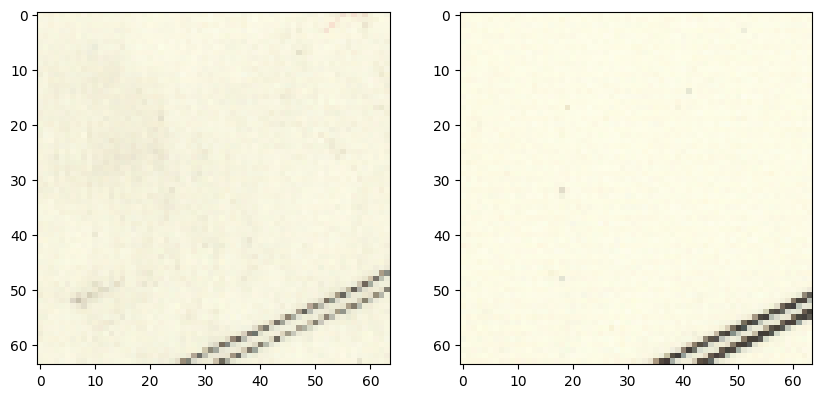

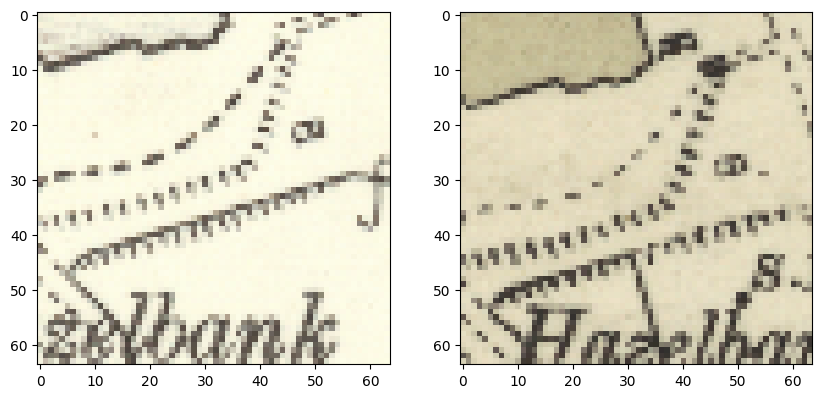

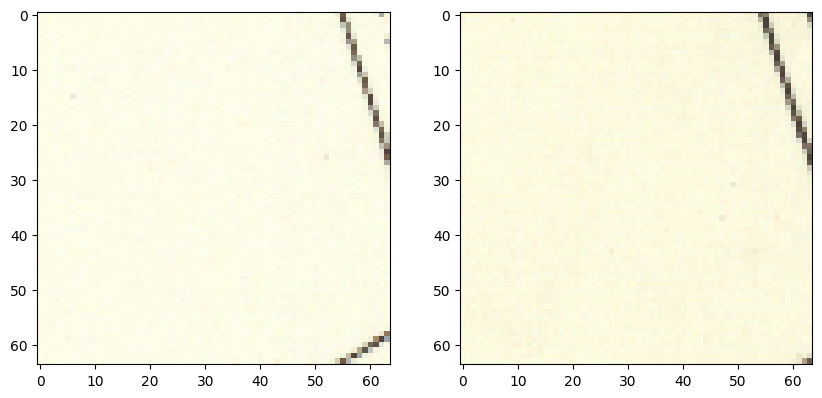

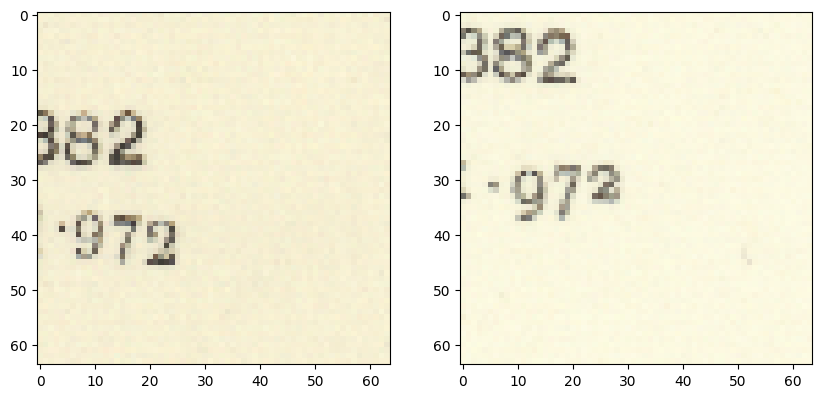

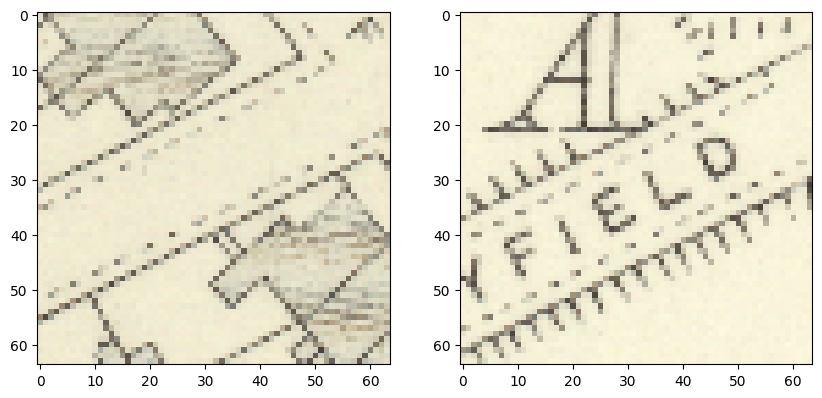

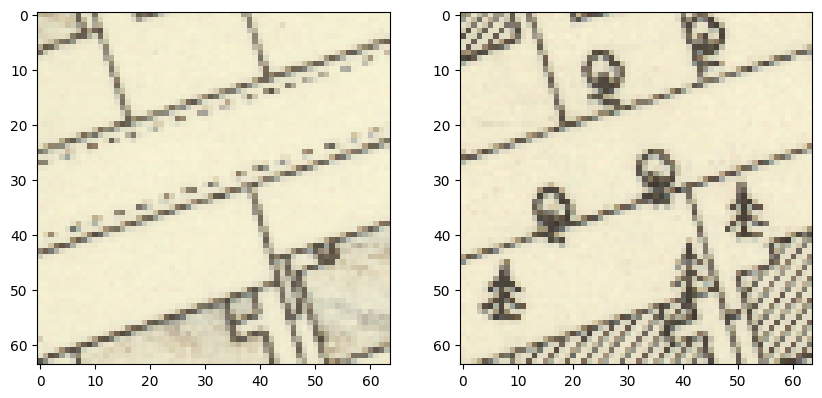

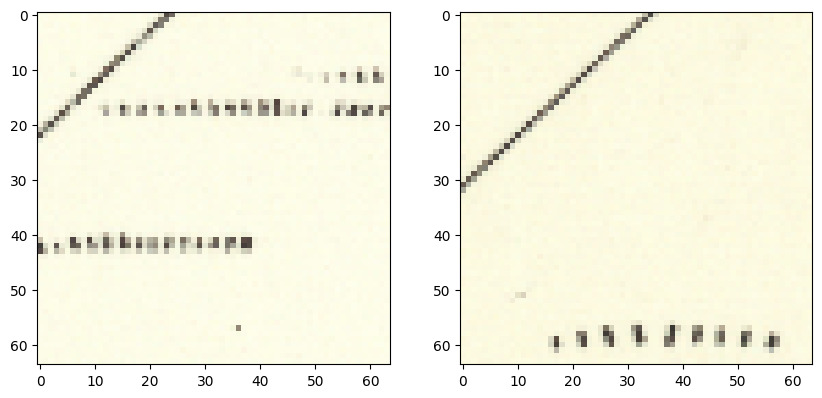

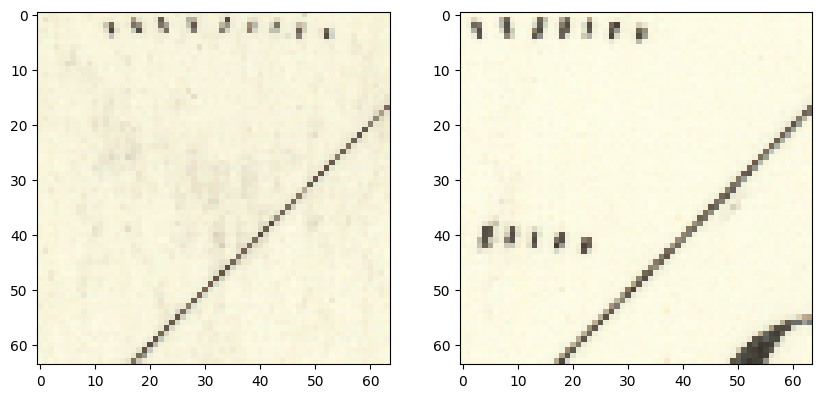

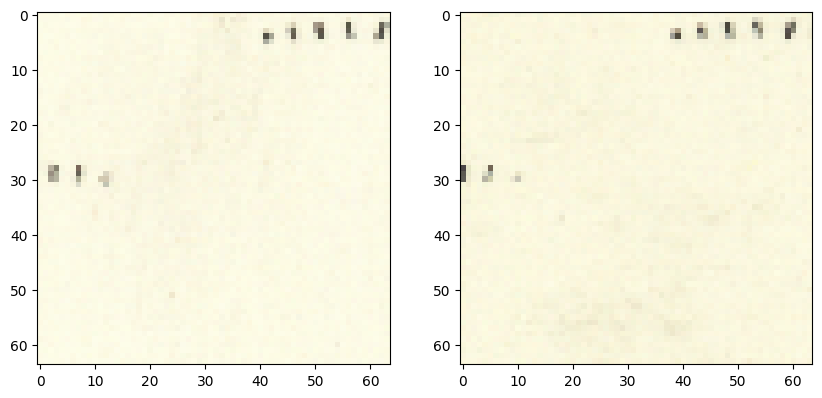

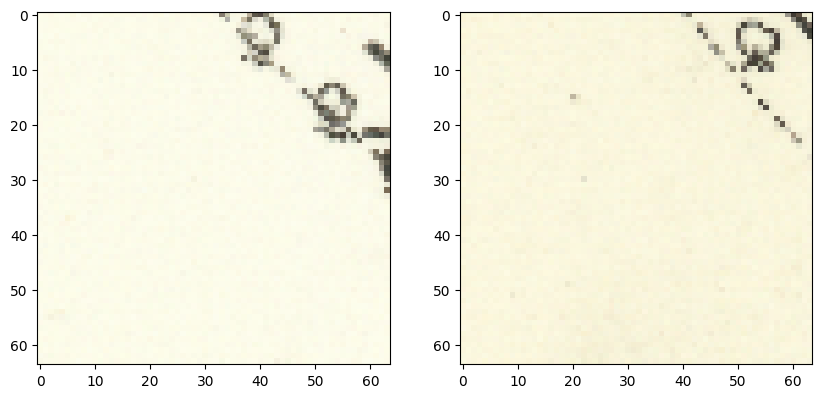

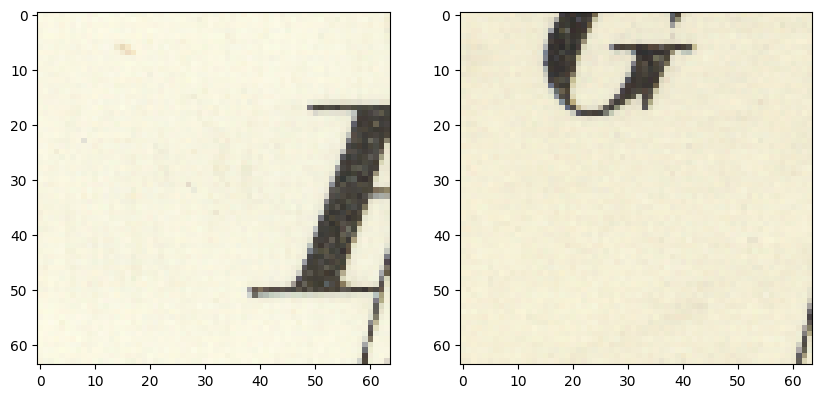

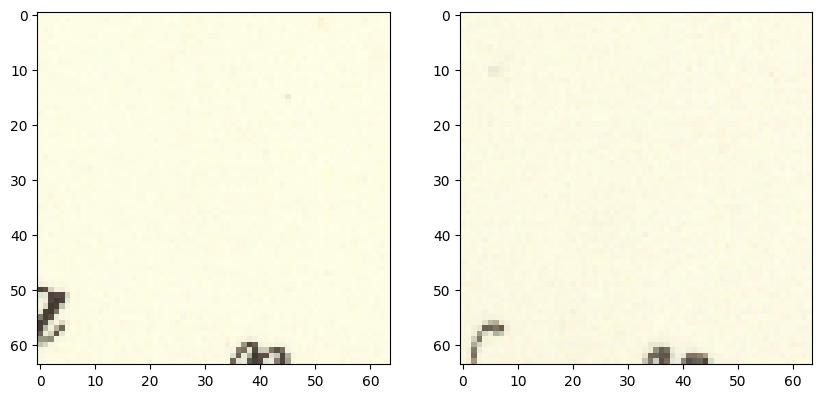

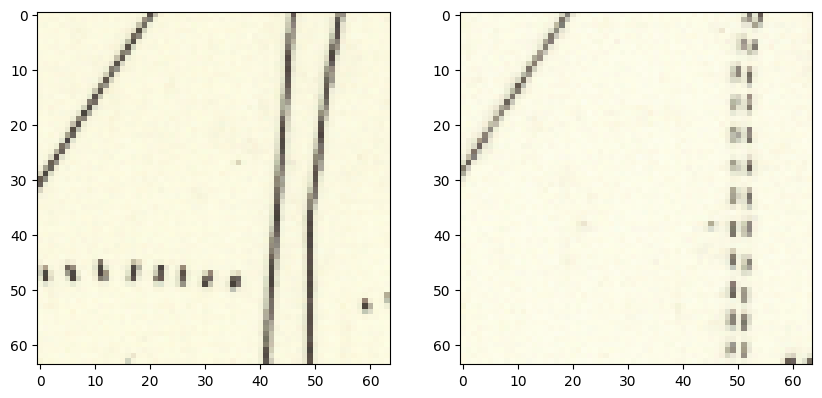

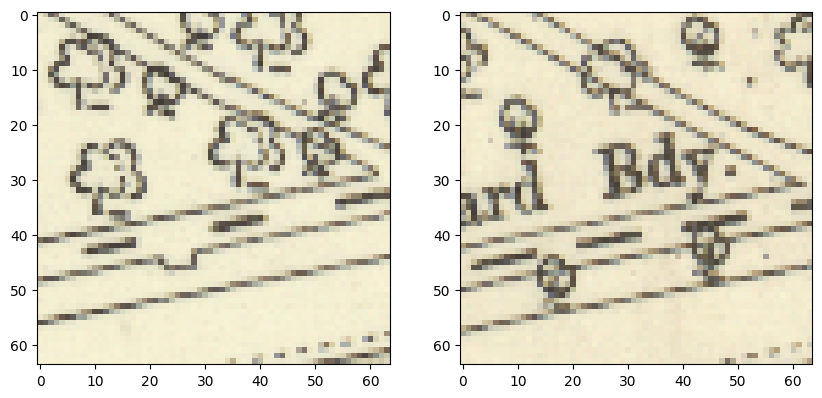

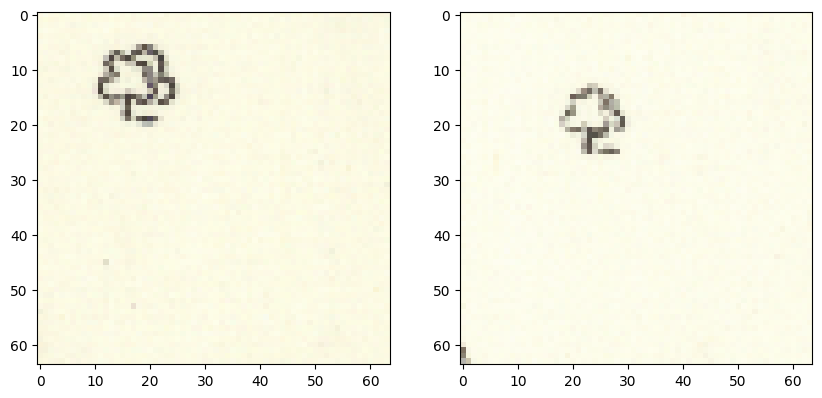

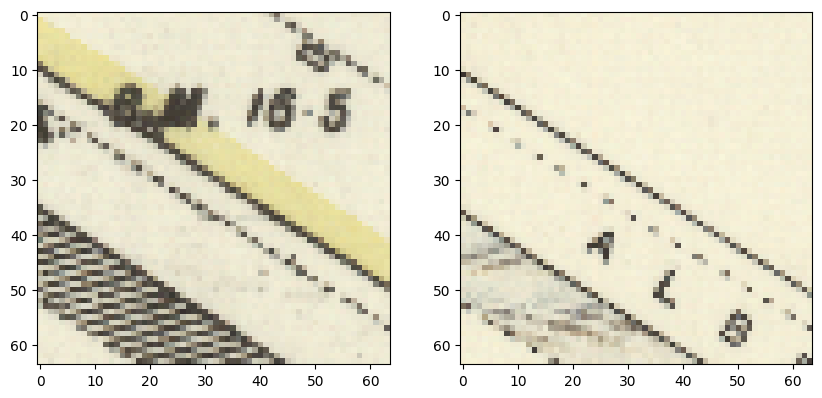

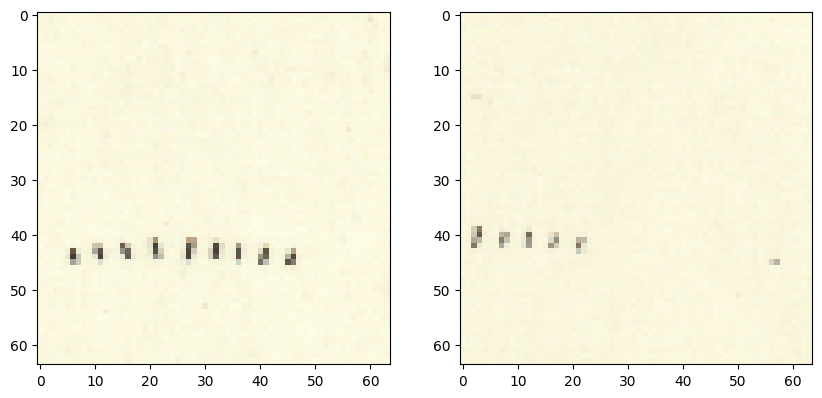

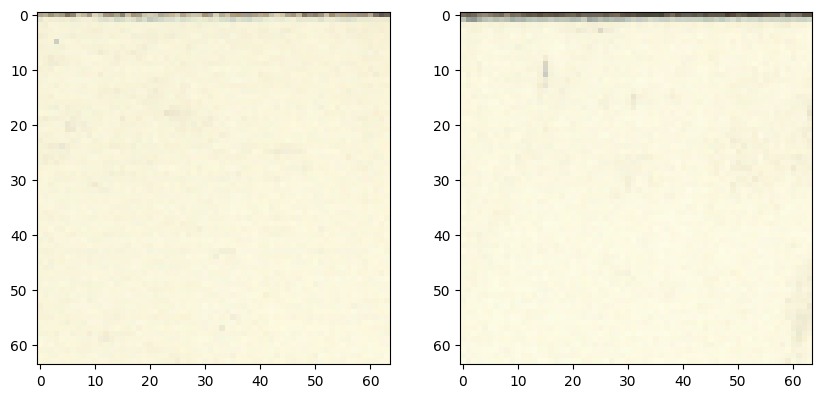

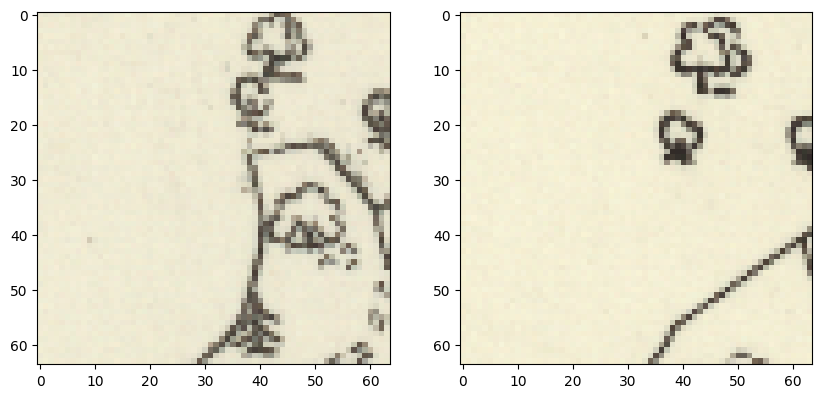

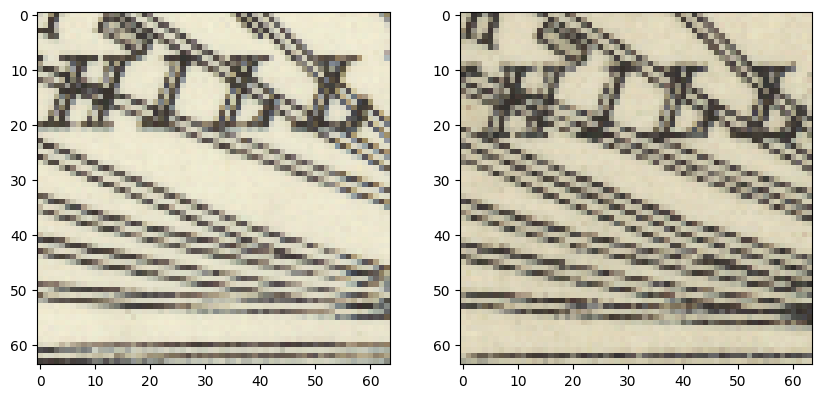

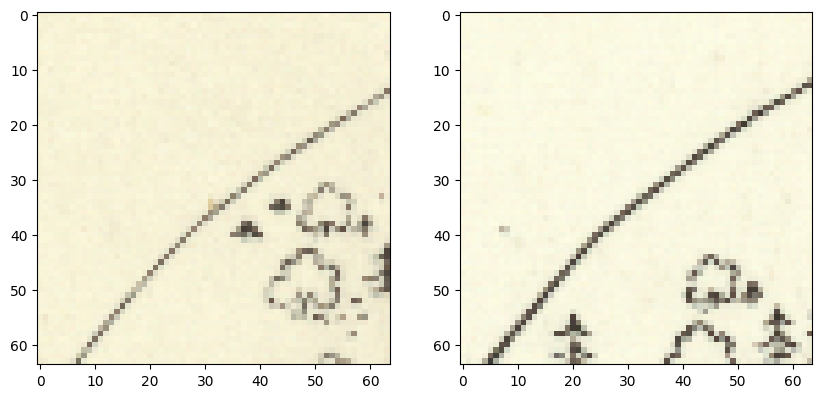

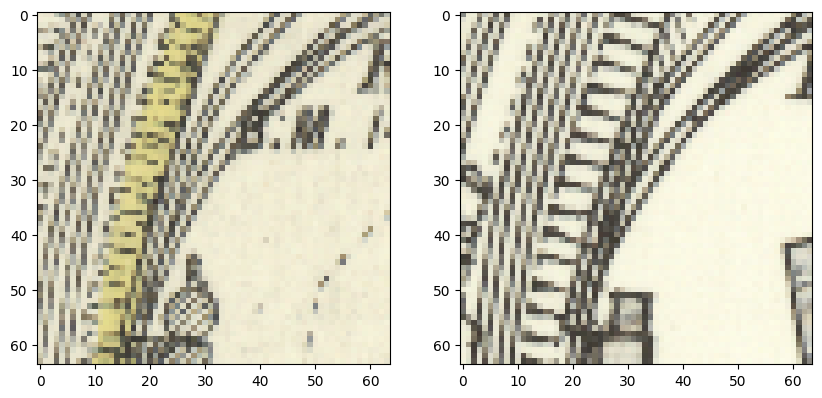

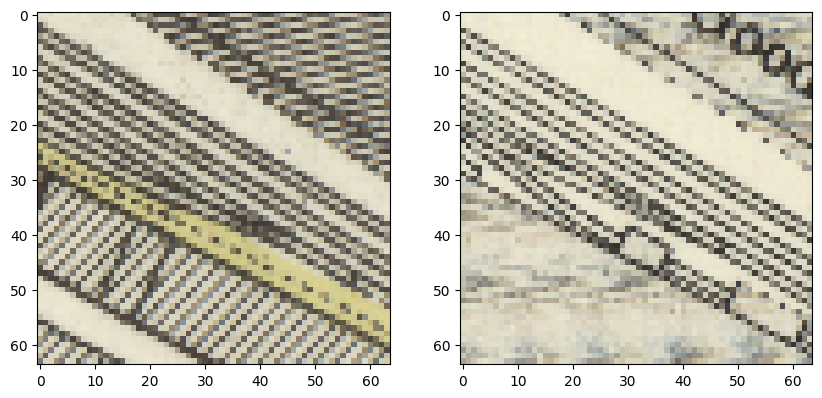

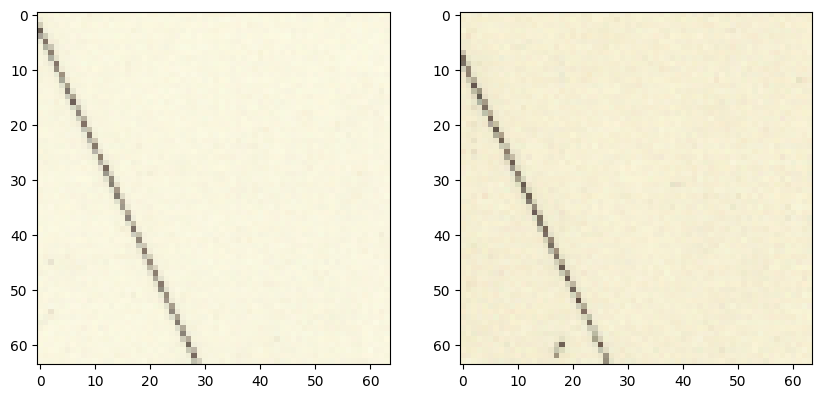

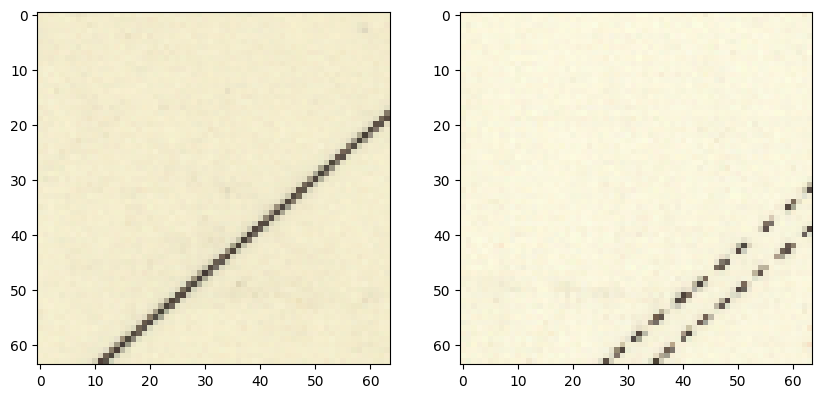

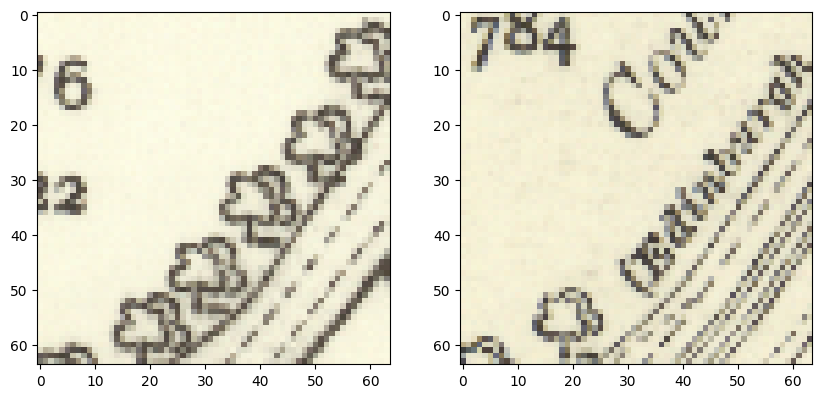

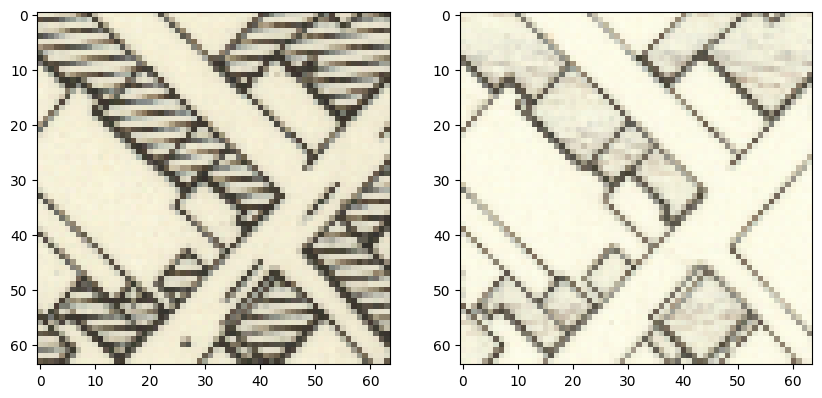

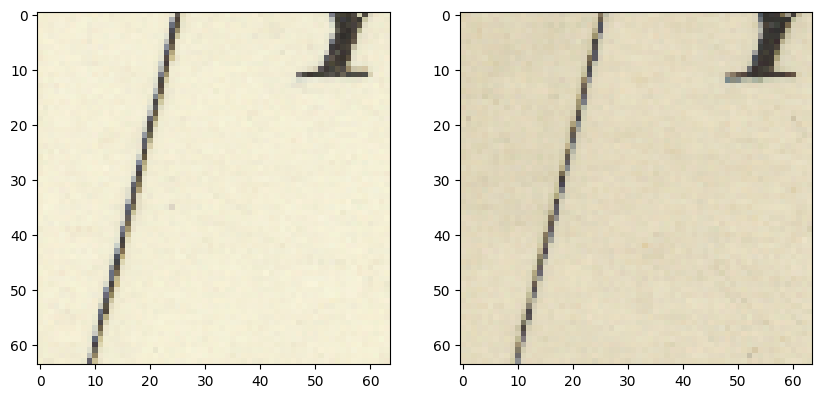

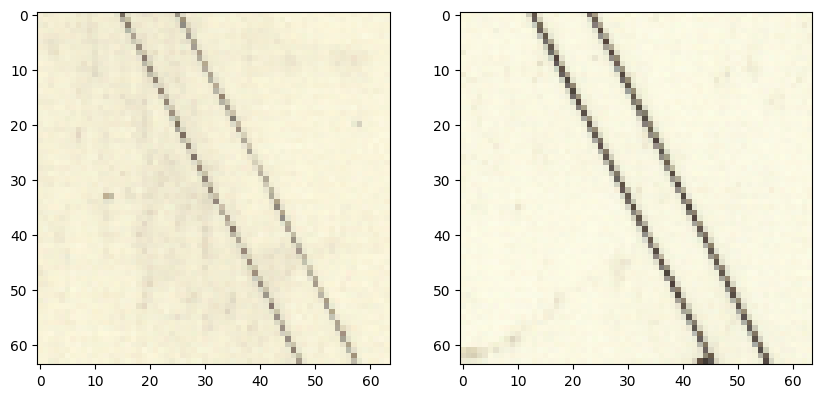

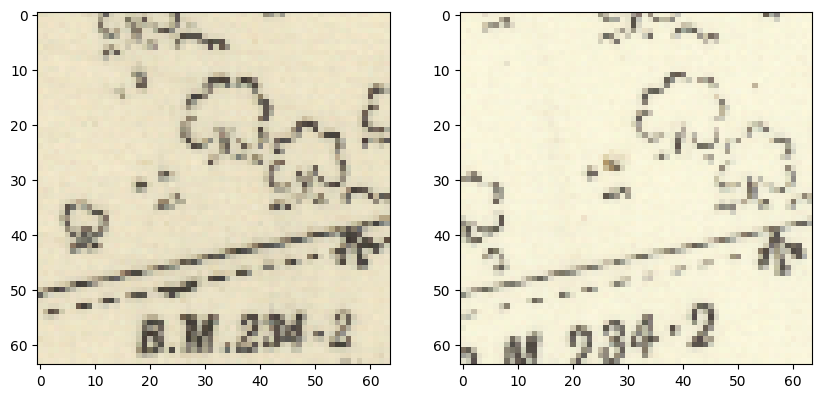

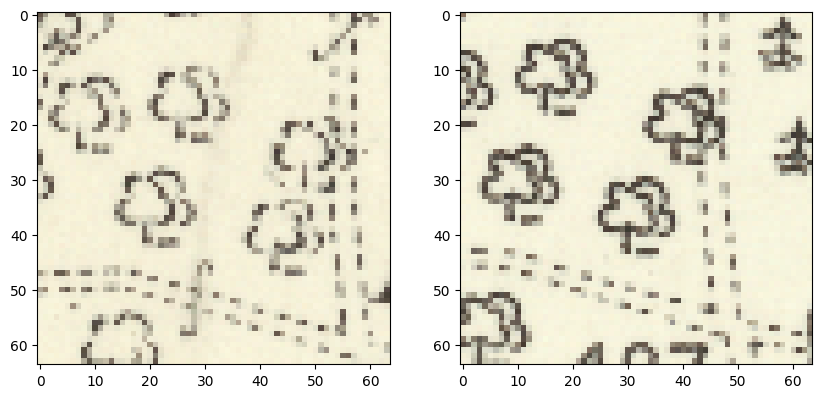

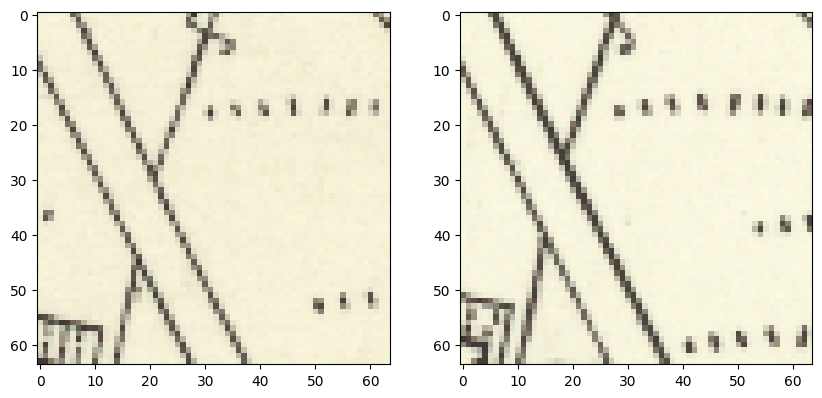

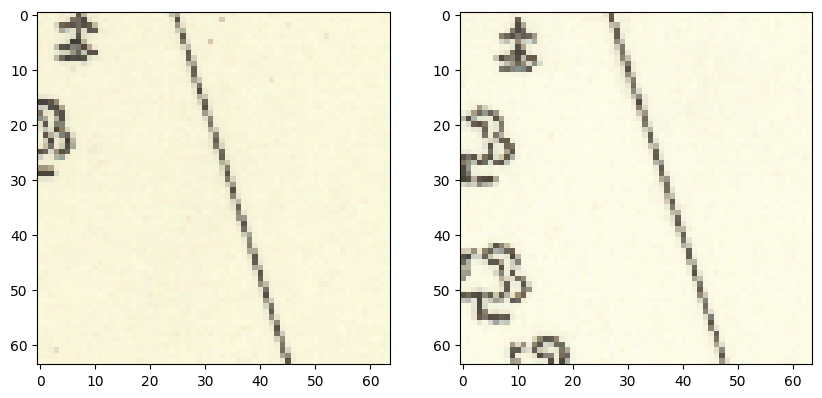

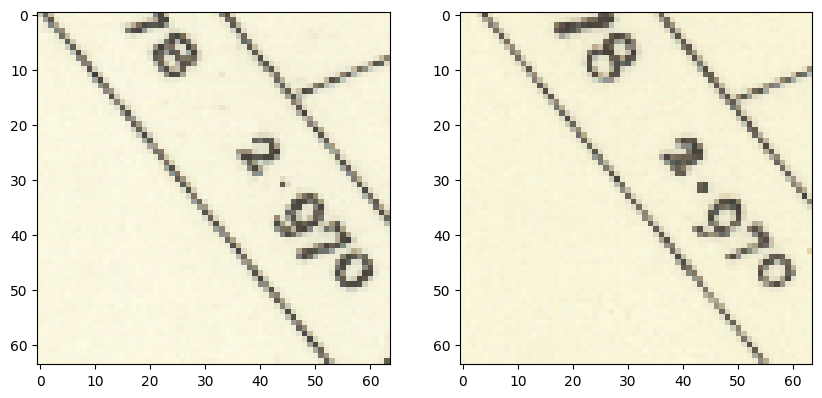

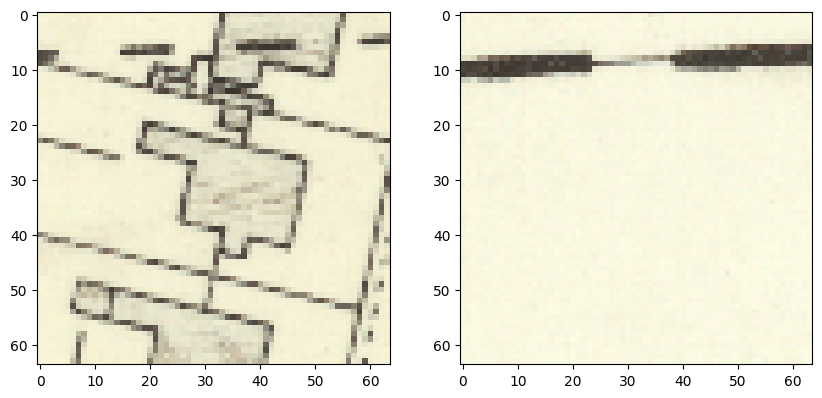

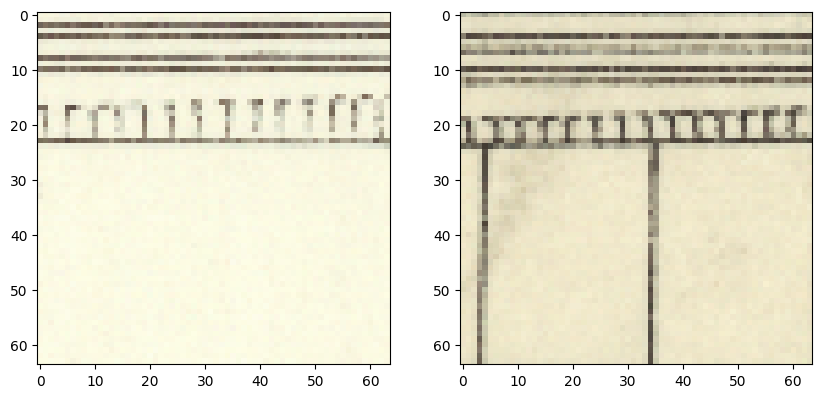

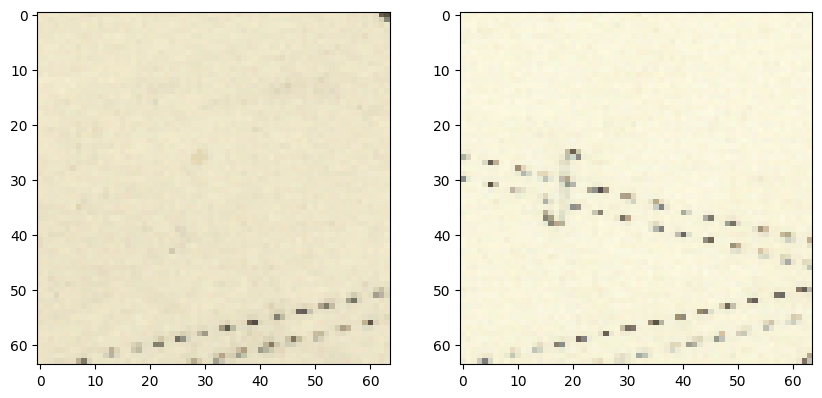

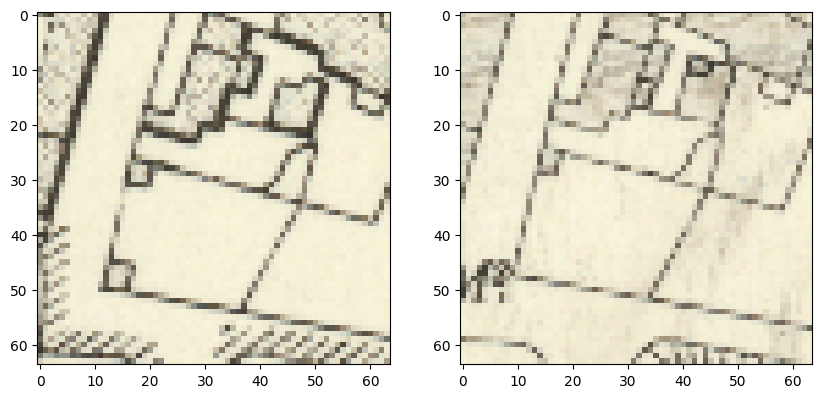

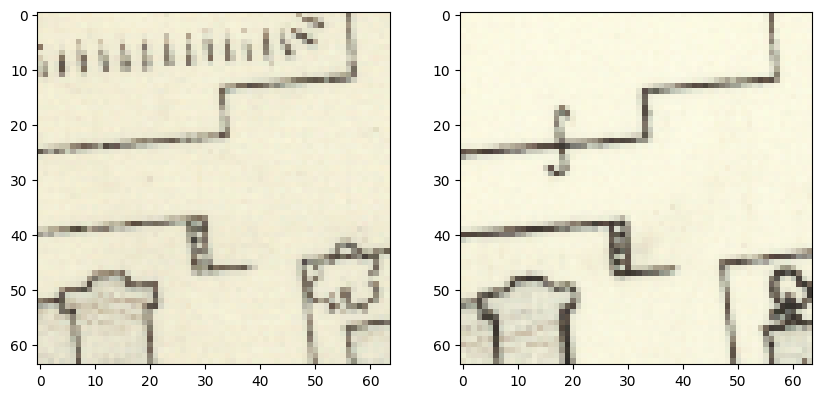

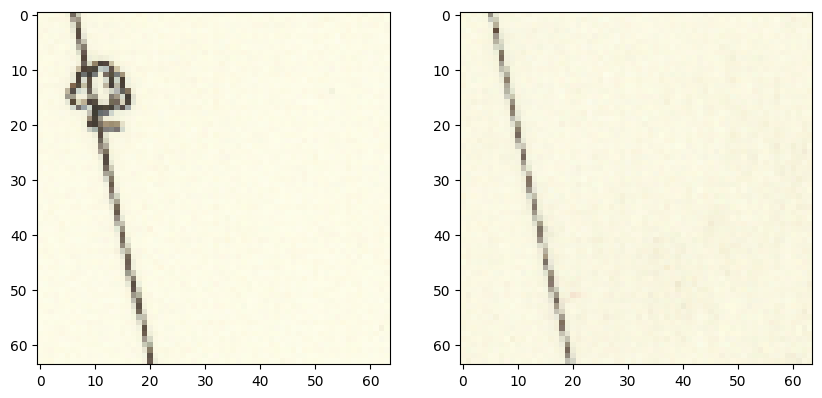

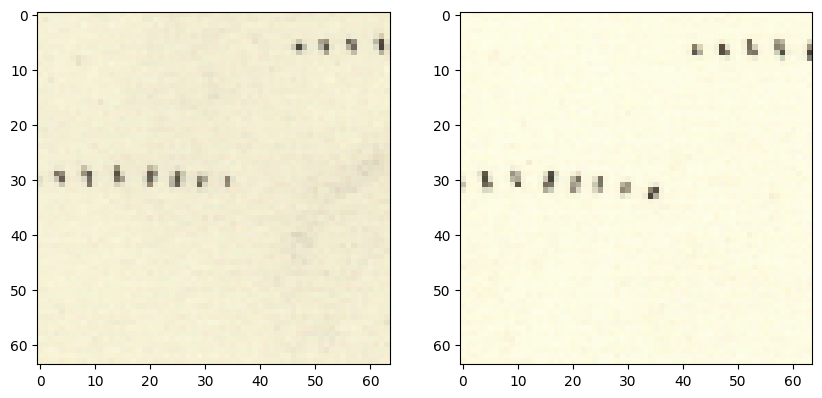

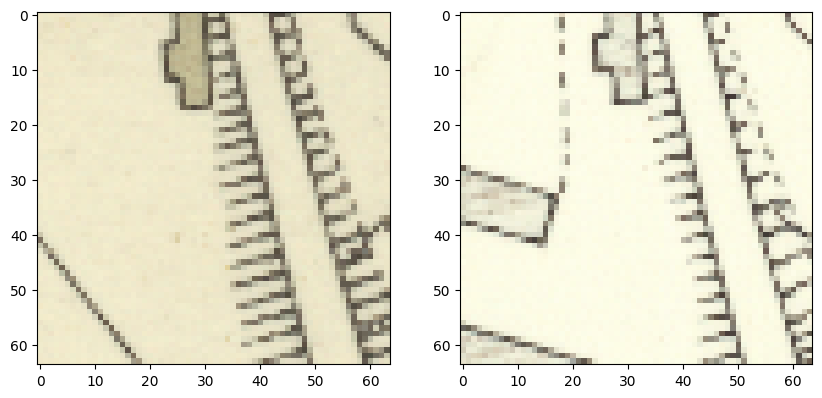

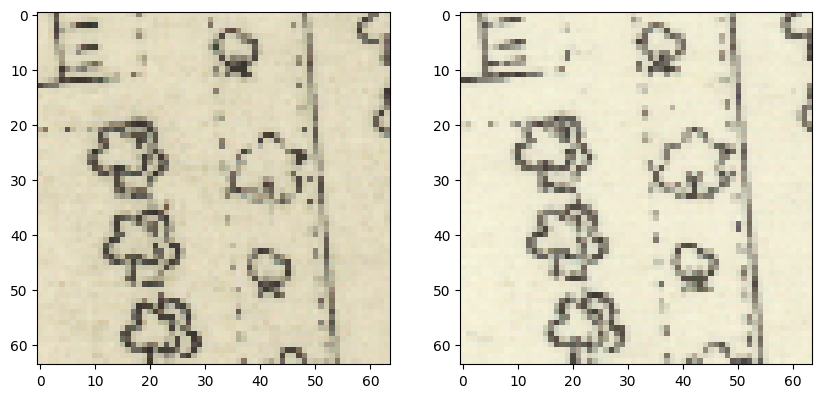

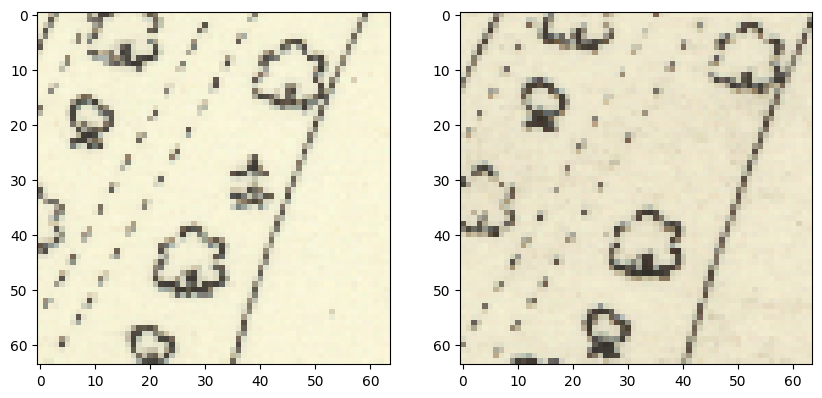

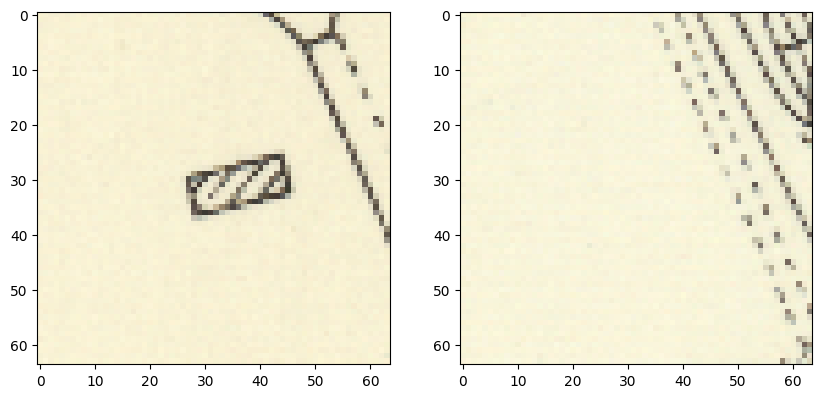

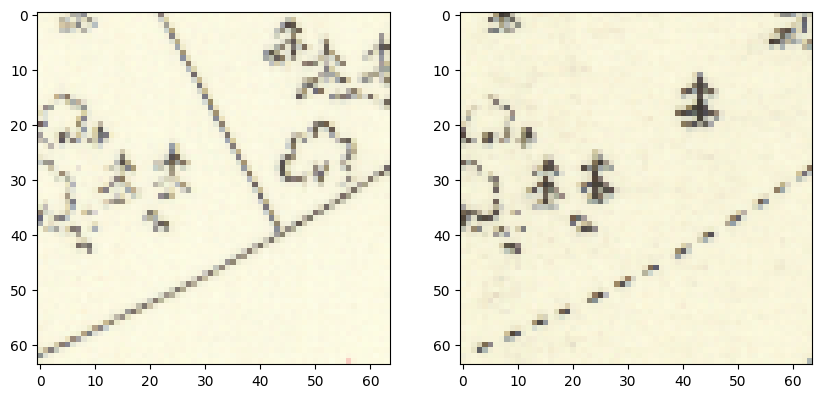

In [121]:
first_batch = next(iter(cl_patch_loader))
patches = [(first_batch[0][i], first_batch[1][i]) for i in range(len(first_batch[0]))]
show_patch_pairs(patches)